In [ ]:
"""
*******************************************************************************

Project: RL, assignment 1
File: warehouse_robot_SARSA.ipynb
Author: Hamid Manouchehri
Email: hmanouch@buffalo.edu
Date: Feb 24, 2025

Description:
Environmet Scenario: Warehouse Robot

License:
This script is licensed under the MIT License.
You may obtain a copy of the License at
    https://opensource.org/licenses/MIT

SPDX-License-Identifier: MIT

Disclaimer:
This software is provided "as is", without warranty of any kind, express or
implied, including but not limited to the warranties of merchantability,
fitness for a particular purpose, and noninfringement. In no event shall the
authors be liable for any claim, damages, or other liability, whether in an
action of contract, tort, or otherwise, arising from, out of, or in connection
with the software or the use or other dealings in the software.

*******************************************************************************
"""

In [1]:
#!/usr/bin/env python3

import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import matplotlib.colors as mcolors
from IPython.display import clear_output
import os

In [2]:
################################
## Custom Function Definition ##
################################
def save_plot_as_img(png_plot_name, dir):
    """ Call this function after plt.plot(...)"""
    
    save_path = os.path.join(dir, png_plot_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print(f"Plot saved at: {save_path}")


def get_state_index(obs):

    index_lookup_table = np.arange(72).reshape((2,6,6))
    
    return index_lookup_table[obs[0], obs[1], obs[2]]

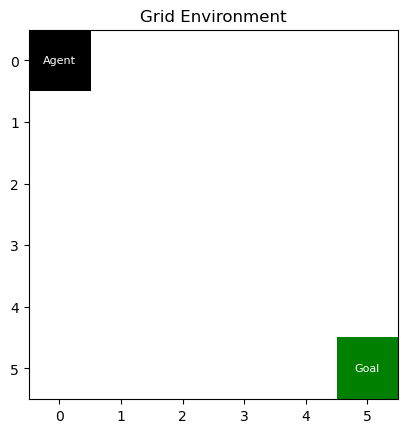

In [3]:
grid_size = 6
grid = np.ones((grid_size, grid_size, 3))
# Define grid size
grid_size = 6  # 6x6 grid

# Initialize grid with default background (White = 4)
grid = np.full((grid_size, grid_size), 1, dtype=int)  # Default to background

# Define agent and goal positions
init_agent_pos = [0, 0]  # Start position
goal_pos = [5, 5]  # Goal position

# Define integer-based color mapping
rgb_colors = {
    "black": 0,   # Agent
    "white": 1,   # Goal
    "red": 2,     # Trap
    "blue": 3,    # Water
    "green": 4,   # Background
    "gray": 5     # Obstacle
}

# Define color list for visualization
color_map = {
    0: "black",
    1: "white",
    2: "red",
    3: "blue",
    4: "green",
    5: "gray"
}

agent_obj_state = {
    0: "no_obj",
    1: "have_obj"
}

# Assign integer values to the grid
grid[tuple(init_agent_pos)] = rgb_colors["black"]  # Agent
grid[tuple(goal_pos)] = rgb_colors["green"]  # Goal

# Create a colormap using actual colors
cmap = mcolors.ListedColormap([color_map[i] for i in range(len(color_map))])

for i in range(6):  # rows
    for j in range(6):  # columns
        text = ""
        if [i, j] == init_agent_pos:
            text = "Agent"
        elif [i, j] == goal_pos:
            text = "Goal"
        
        # Only annotate if there is text to display
        if text:
            plt.text(j, i, text, ha="center", va="center", color="white", fontsize=8)


# Display the grid with correct colors
plt.imshow(grid, cmap=cmap, vmin=0, vmax=len(color_map) - 1)
plt.title("Grid Environment")
plt.show()


In [4]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self, max_timesteps):
        # Initializes the class
        # Define action and observation space
        self.observation_space = spaces.Discrete(36)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps  # TODO
        self.reward = 0
        
        self.timestep = 0
        self.agent_carry_obj = False
        self.agent_pos = [0,0]
        self.goal_pos = [5,5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]

        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]


    # Reset function
    def reset(self, **kwargs):
        self.agent_carry_obj = False
        self.agent_pos = [0,0]
        self.goal_pos = [5,5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]
        self.reward = 0
        self.timestep = 0
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]
        observation = np.append(int(self.agent_carry_obj),np.array(self.agent_pos))

        
        info = {}
        
        return observation, info


    def pick_up_obj(self):
        self.state[tuple(self.object_pos)] = rgb_colors["white"]
        self.agent_carry_obj = True


    def drop_off_obj(self):
        self.state[tuple(self.goal_pos)] = rgb_colors["white"]
        self.agent_carry_obj = False


    def step(self, action):
        self.reward -= 1
        terminated = False

        # Compute the potential new position based on the action.
        new_agent_pos = self.agent_pos.copy()
        if action == 0:  # down
            new_agent_pos[0] += 1
        elif action == 1:  # up
            new_agent_pos[0] -= 1
        elif action == 2:  # right
            new_agent_pos[1] += 1
        elif action == 3:  # left
            new_agent_pos[1] -= 1

        # Ensure the new position is within bounds.
        new_agent_pos = np.clip(new_agent_pos, 0, 5).tolist()

        # Obstacle avoidance: If the new position is the obstacle, do not update agent_pos.
        if np.array_equal(new_agent_pos, self.obstacle_1_pos):
            self.reward -= 25  # Apply penalty
            # Optionally, you might decide to leave the agent in place:
            # new_agent_pos remains as the current position.
        else:
            # Otherwise, update the agent's position.
            self.agent_pos = new_agent_pos

        # Update the grid state.
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        if not self.agent_carry_obj:
            self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]

        # Create the observation.
        observation = np.append(int(self.agent_carry_obj), np.array(self.agent_pos))

        # Check for picking up the object.
        if np.array_equal(self.agent_pos, self.object_pos) and (self.agent_carry_obj == False):
            self.pick_up_obj()
            self.reward += 25
            self.state[tuple(self.object_pos)] = rgb_colors["black"]

        # Check for dropping off the object.
        if np.array_equal(self.agent_pos, self.goal_pos) and (self.agent_carry_obj == True):
            self.drop_off_obj()
            self.reward += 100
            terminated = True
            self.state[tuple(self.goal_pos)] = rgb_colors["black"]

        # Termination condition based on timestep.
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            terminated = True

        # Check if agent remains within permitted cells.
        if np.all((np.asarray(self.agent_pos) >= 0) & (np.asarray(self.agent_pos) <= 5)):
            truncated = True
        else:
            truncated = False

        info = {}
        return observation, self.reward, terminated, truncated, info



    # Render function: Visualizes the environment
    def render(self):

        cmap = mcolors.ListedColormap([color_map[i] for i in range(len(color_map))])
        plt.imshow(self.state, cmap=cmap, vmin=0, vmax=len(color_map) - 1)
        
        # Annotate the grid with text labels
        for i in range(6):  # rows
            for j in range(6):  # columns
                label = ""
                if np.array_equal([i, j], self.agent_pos):
                    label = "Agent"
                elif np.array_equal([i, j], self.goal_pos):
                    label = "Goal"
                elif np.array_equal([i, j], self.object_pos):
                    label = "Obj"
                elif np.array_equal([i, j], self.obstacle_1_pos):
                    label = "Obs"
                
                if label:
                    plt.text(j, i, label, ha="center", va="center", color="white", fontsize=8)
        
        plt.title("Grid Environment")
        plt.show()

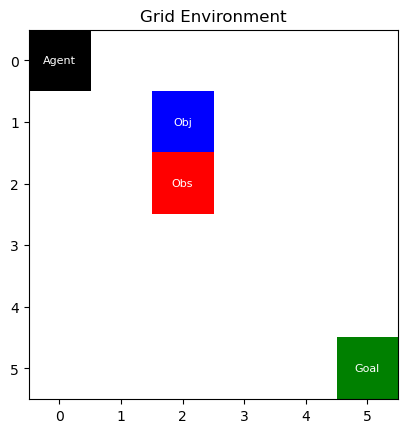

In [5]:
##############################
## Init environment & Reset ##
##############################
max_timesteps = 500  # TODO

env = GridEnvironment(max_timesteps)
terminated, truncated = False, False
observation, info = env.reset()
env.render()

In [6]:
##############################
######## SARSA Method ########
##############################
def SARSA(env, num_episodes=1000, max_steps=100, alpha=0.1, gamma=0.99,
          epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, det=0):
    grid_size = 6
    num_states = grid_size * grid_size
    num_actions = env.action_space.n
    epsilon_arr = []
    
    Q_table = np.zeros((num_states * 2, num_actions))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        obs, info = env.reset()
        state_idx = get_state_index(obs)
        total_rewards = 0
        
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state_idx, :])
        
        for step in range(max_steps):
            obs, reward, terminated, truncated, info = env.step(action)
            total_rewards += reward
            new_state_idx = get_state_index(obs)
            
            if np.random.rand() < epsilon:
                new_action = env.action_space.sample()
            else:
                new_action = np.argmax(Q_table[new_state_idx, :])
            
            if np.random.rand() < det:
                reward = -1
            
            Q_table[state_idx, action] += alpha * (reward + gamma * Q_table[new_state_idx, new_action] - Q_table[state_idx, action])
            
            state_idx = new_state_idx
            action = new_action
            
            if terminated:
                break
        
        # Decay epsilon after each episode.
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_all_episodes.append(total_rewards)
        epsilon_arr.append(epsilon)

    return Q_table, rewards_all_episodes, epsilon_arr


In [7]:
def test(Q_table, num_episodes=10, max_steps=100, det=0):

    
    index_lookup_table = np.arange(72).reshape((2,6,6))
    rewards_all_episodes = []
    
    for episode in range(num_episodes):
        terminated = 0
        obs, info = env.reset()
        state_idx = get_state_index(obs)
        total_rewards = 0
        for step in range(max_steps):
            
            action = np.argmax(Q_table[state_idx, :])
            
            if np.random.rand() < det:  # Stochastic
                reward=-1
            else:
                obs, reward, terminated, truncated, info = env.step(action)

            # print("agent location: ", env.agent_pos, "action", action)
            
            total_rewards += reward
            new_state_idx = get_state_index(obs)
            
            state_idx = new_state_idx
            
            if terminated:# or truncated:
                break
        
        # Decay epsilon after each episode.
        rewards_all_episodes.append(total_rewards)

    
    return  rewards_all_episodes


trained Q-table:

 [[ -66.69789865    4.92747417   92.86678576   -8.2926985 ]
 [ 107.62955825  -16.97525558  -49.12912985  -59.37049352]
 [  84.62932257 -284.26683141 -363.05546278 -337.37513194]
 [-373.92890555 -362.32506198 -373.10688121 -298.68174322]
 [-378.48068349 -380.46759456 -378.53735345 -378.02389241]
 [-378.36913877 -386.92325078 -380.67689005 -381.6354278 ]
 [-331.46214592 -147.24602542   51.03781906 -263.37348336]
 [ -83.22466627   30.1836892   121.30527626  -91.78561757]
 [  19.65780075  -52.96197163  143.90535861 -231.56030531]
 [-377.61520794 -366.73664972 -368.05825149 -334.31798401]
 [-384.21216431 -376.9785746  -375.41359046 -377.44787412]
 [-387.50331542 -386.04673768 -375.64451822 -376.86271877]
 [-384.47491816 -226.28579994 -377.38138907 -388.28013493]
 [-386.67509076   24.01334401 -330.53138302 -363.80406365]
 [   0.            0.            0.            0.        ]
 [-396.49486938 -383.27596142 -393.99491647 -407.7568158 ]
 [-392.75443986 -395.06035952 -383.5

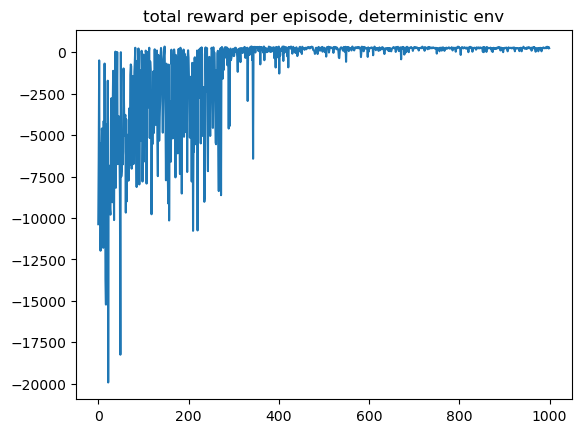

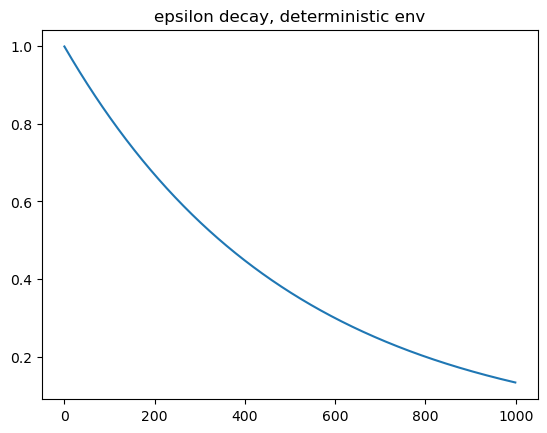

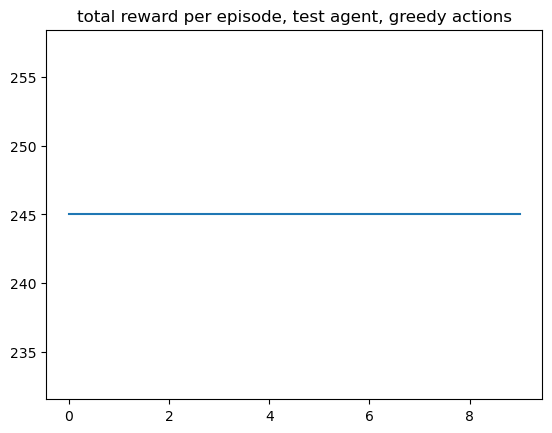

In [8]:
############################################
####### SARSA Training Deterministic #######
############################################
det = 0.0  # TODO
num_episodes = 1000  # TODO
max_steps = 100  # TODO
alpha = 0.1  # TODO learning rate
gamma = 0.99  # TODO  discount factor
epsilon = 1.0  # TODO
epsilon_min = 0.1  # TODO
epsilon_decay = 0.998  # TODO
dir_to_save_data = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/data/test/"
# dir_to_save_data = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/data/sarsa_det_gamma_1/"  # TODO
os.makedirs(dir_to_save_data, exist_ok=True)

trained_Q_table, rewards_all_episodes, epsilon_arr = SARSA(env, num_episodes=num_episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma, epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,det=det)
print("\ntrained Q-table:\n\n", trained_Q_table)

plt.figure(1)
plt.plot(rewards_all_episodes)
plt.title('total reward per episode, deterministic env')
save_plot_as_img('sarsa_deterministic_reward_per_episode.png', dir_to_save_data)

plt.figure(2)
plt.plot(epsilon_arr)
plt.title('epsilon decay, deterministic env')
save_plot_as_img('sarsa_deterministic_epsilon_decay.png', dir_to_save_data)

pkl_file_name = 'sarsa_Q_table_deterministic.pkl'  # TODO
with open(dir_to_save_data + pkl_file_name, 'wb') as f:
    pickle.dump(trained_Q_table, f)
# with open(dir_to_save_pkl_file + pkl_file_name, 'rb') as f:
#     Q_table = pickle.load(f)


num_episodes = 10  # TODO
max_steps = 100  # TODO

t = test(trained_Q_table, num_episodes=num_episodes, max_steps=max_steps, det=det)
plt.figure(3)
plt.plot(t)
plt.title('total reward per episode, test agent, greedy actions')
save_plot_as_img('sarsa_deterministic_test_agent.png', dir_to_save_data)


trained Q-table:

 [[-147.97511282  -57.61665692   81.64049957  -20.90246589]
 [ -36.71330184  -31.08277266  106.37519913  -66.92451404]
 [ 144.87287617   33.15110803 -102.67632433   20.12432304]
 [-363.1061592  -295.04721587 -357.63430543   52.24433511]
 [-372.14411721 -370.65804671 -366.43717844 -275.22396949]
 [-367.16328324 -369.23814172 -371.86702141 -367.31894481]
 [-385.86332336   -4.60738312 -202.5024326  -371.06231013]
 [-377.3679175  -282.82513213   84.97545761 -288.47506067]
 [-111.2242726  -106.24988129  142.64366284 -147.45734041]
 [-371.04841152 -363.55235799 -366.94899388 -313.40918136]
 [-360.57923757 -357.69612623 -373.50726341 -383.17334807]
 [-371.38233493 -361.53633493 -358.22075695 -361.18632906]
 [-409.85410515 -386.27819896 -366.76228363 -382.50234483]
 [-395.86288524 -250.4168374  -388.85446787 -392.90920948]
 [   0.            0.            0.            0.        ]
 [-387.31762486 -384.41143269 -384.95454328 -381.89769451]
 [-377.83786938 -365.00306472 -375.6

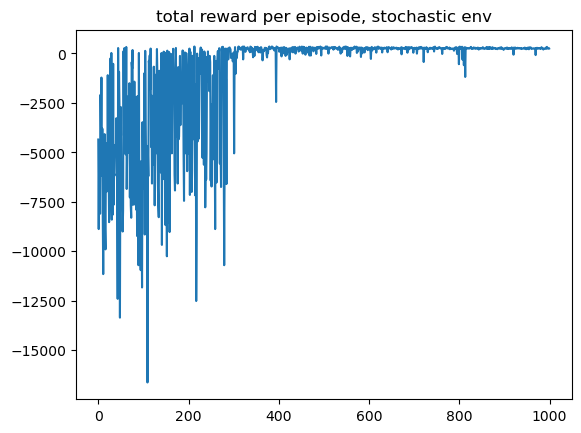

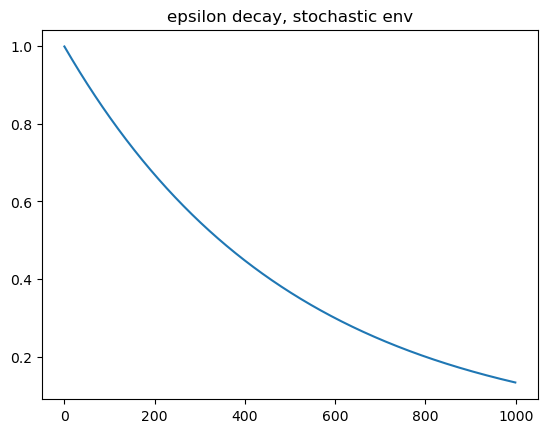

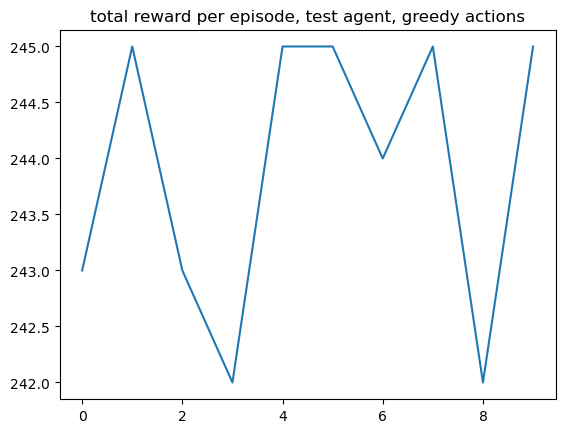

In [9]:
#########################################
###### SARSA Training Stochastic ########
#########################################
det = 0.1  # TODO
num_episodes = 1000  # TODO
max_steps = 100  # TODO
alpha = 0.1  # TODO learning rate
gamma = 0.99  # TODO  discount factor
epsilon = 1.0  # TODO
epsilon_min = 0.1  # TODO
epsilon_decay = 0.998  # TODO
dir_to_save_data = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/data/test/"  # TODO
# dir_to_save_data = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/data/sarsa_stoch_gamma_0.1/"  # TODO
os.makedirs(dir_to_save_data, exist_ok=True)

trained_Q_table, rewards_all_episodes, epsilon_arr = SARSA(env, num_episodes=num_episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma, epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,det=det)

print("\ntrained Q-table:\n\n", trained_Q_table)
plt.figure(1)
plt.plot(rewards_all_episodes)
plt.title('total reward per episode, stochastic env')
save_plot_as_img('sarsa_stochastic_reward_per_episode.png', dir_to_save_data)


plt.figure(2)
plt.plot(epsilon_arr)
plt.title('epsilon decay, stochastic env')
save_plot_as_img('sarsa_stochastic_epsilon_decay.png', dir_to_save_data)

pkl_file_name = 'sarsa_Q_table_stochastic.pkl'  # TODO
with open(dir_to_save_data + pkl_file_name, 'wb') as f:
    pickle.dump(trained_Q_table, f)
# with open(dir_to_save_data + pkl_file_name, 'rb') as f:
#     trained_Q_table = pickle.load(f)


num_episodes = 10  # TODO
max_steps = 100  # TODO

t = test(trained_Q_table, num_episodes=num_episodes, max_steps=max_steps, det=det)
plt.figure(3)
plt.plot(t)
plt.title('total reward per episode, test agent, greedy actions')
save_plot_as_img('sarsa_stochastic_test_agent.png', dir_to_save_data)

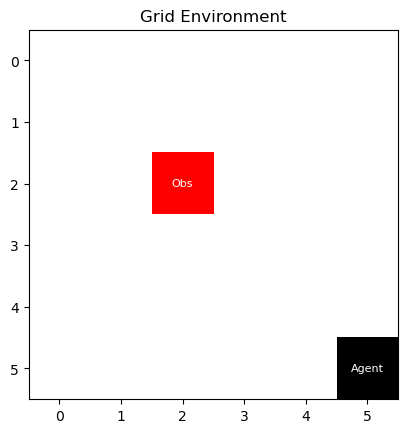

In [10]:
#########################################
## Single Episode of Testing The Agent ##
#########################################
det = 0.  # TODO
observation, info = env.reset()
env.render()
time.sleep(1)  # Show initial configuration of env
state_idx = get_state_index(observation)

for step in range(100):
    action = np.argmax(trained_Q_table[state_idx, :])
    
    if np.random.rand() < det:  # stochastic
        reward = -1
    else:
        observation, reward, terminated, truncated, info = env.step(action)
    
    new_state_idx = get_state_index(observation)
    state_idx = new_state_idx
    
    env.render()
    time.sleep(.05)  # TODO Pause to see the update
    # input("enter:")

    clear_output(wait=True)  # Clear the previous output so the next plot replaces it
    
    if terminated:
        break